# Text data (20newsgroups) Preprocess

test

In [1]:

#
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



from sklearn.datasets import fetch_20newsgroups

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import f1_score


from sklearn.feature_extraction.text import TfidfVectorizer

from time import time


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## fit and evaluate the clustering

from collections import defaultdict
# from time import time

from tqdm.notebook import tqdm


# define ENV



In [2]:
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]


# Load the 20 newsgroups dataset
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), categories=categories,)

# Create a DataFrame from the dataset
df = pd.DataFrame({'text': newsgroups.data, 'label': newsgroups.target})

# Map target labels to target names
df['label'] = df['label'].map(lambda x: newsgroups.target_names[x])

true_k = len(df.label.unique())
labels = df['label']

print(f"Number of unique labels: {true_k}")

# Explore the dataset
print(df.head())
print(df['label'].value_counts())


Number of unique labels: 4
                                                text               label
0  My point is that you set up your views as the ...         alt.atheism
1  \nBy '8 grey level images' you mean 8 items of...       comp.graphics
2  FIRST ANNUAL PHIGS USER GROUP CONFERENCE\n\n  ...       comp.graphics
3  I responded to Jim's other articles today, but...  talk.religion.misc
4  \nWell, I am placing a file at my ftp today th...       comp.graphics
label
sci.space             987
comp.graphics         973
alt.atheism           799
talk.religion.misc    628
Name: count, dtype: int64


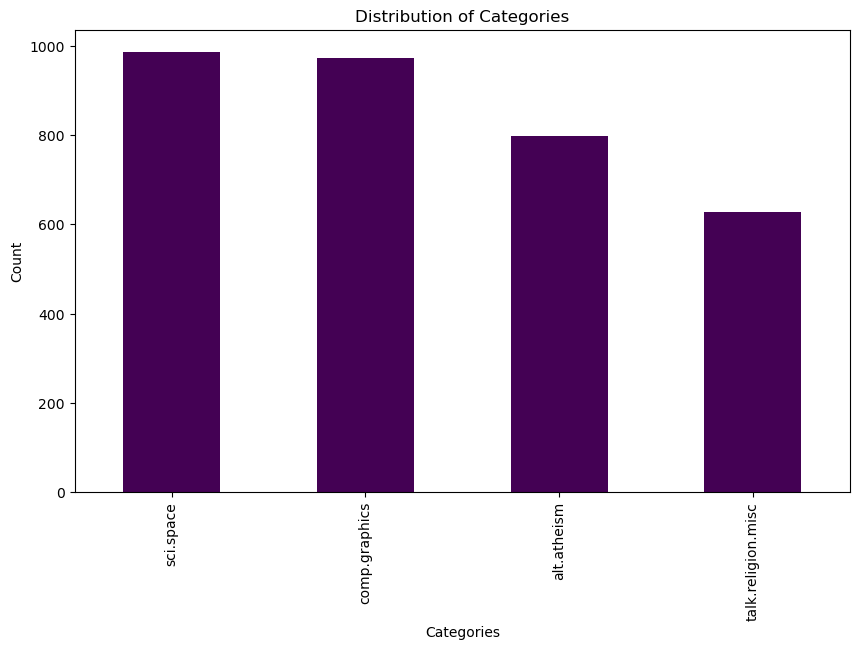

In [3]:
# Visualize the distribution of categories
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar', colormap='viridis')
plt.title('Distribution of Categories')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

## Vectorize - TFIDF


In [4]:


vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(df.text)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.350 s
n_samples: 3387, n_features: 7929


After ignoring terms that appear in more than 50% of the documents (as set by max_df=0.5) and terms that are not present in at least 5 documents (set by min_df=5), the resulting number of unique terms n_features is around 8,000. We can additionally quantify the sparsity of the X_tfidf matrix as the fraction of non-zero entries divided by the total number of elements.

In [5]:


print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

0.007


We find that around 0.7% of the entries of the X_tfidf matrix are non-zero.

In [6]:


evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

## Performing dimensionality reduction using LSA
A n_init=1 can still be used as long as the dimension of the vectorized space is reduced first to make k-means more stable. For such purpose we use TruncatedSVD, which works on term count/tf-idf matrices. Since SVD results are not normalized, we redo the normalization to improve the KMeans result. Using SVD to reduce the dimensionality of TF-IDF document vectors is often known as latent semantic analysis (LSA) in the information retrieval and text mining literature.

In [7]:
# from sklearn.decomposition import TruncatedSVD
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 0.387 s
Explained variance of the SVD step: 18.4%


In [8]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 0.05 ± 0.04 s 
Homogeneity: 0.407 ± 0.003
Completeness: 0.444 ± 0.023
V-measure: 0.424 ± 0.011
Adjusted Rand-Index: 0.319 ± 0.022
Silhouette Coefficient: 0.030 ± 0.001


## Top terms per cluster
Since TfidfVectorizer can be inverted we can identify the cluster centers, which provide an intuition of the most influential words for each cluster. See the example script Classification of text documents using sparse features for a comparison with the most predictive words for each target class.

In [9]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: space launch orbit shuttle nasa earth moon like mission lunar 
Cluster 1: thanks graphics image file know program files looking help does 
Cluster 2: just think don like time know ve does good did 
Cluster 3: god people jesus bible believe don say think christian religion 


# Data prepare for RLCO

In [10]:
## check the data shape for RLCO
print(f"X_lsa_shape: {X_lsa.shape}")

print(f"X_lsa example:\n{X_lsa[0]}")

# print the type of X_lsa
print(f"X_lsa dtype: {type(X_lsa)}")

X_lsa_shape: (3387, 100)
X_lsa example:
[ 0.39008276  0.1761134  -0.07393098 -0.09478746  0.0301543   0.02447874
  0.02554447 -0.05019728  0.10963351  0.22354344 -0.28405772 -0.01725997
  0.00256282  0.0177942  -0.02875221  0.04479511 -0.03013657 -0.01448291
  0.03118883 -0.04598425 -0.10281503 -0.05730681 -0.05891308 -0.11127317
  0.15277078 -0.09637717 -0.11215201  0.11187152 -0.12091421  0.12728141
  0.05601798  0.00389288  0.04373277 -0.0144718   0.05688081 -0.03020233
 -0.0039928   0.00078686  0.18630358 -0.08060931  0.14989418  0.03146082
  0.08710176 -0.14835351  0.03557797  0.06227237 -0.16174642 -0.09049975
 -0.04548376  0.00373758 -0.01534472  0.00082157  0.15436778 -0.12046364
 -0.06547458 -0.09110594 -0.01787721 -0.00108841 -0.07886727 -0.03655853
  0.03140194 -0.03638541  0.12393725 -0.06570064  0.02207847 -0.03239049
 -0.13683326 -0.1435301   0.0440783   0.02917844 -0.06640713  0.02172991
  0.04639438 -0.03790475 -0.02316326  0.00911091 -0.10627822  0.00861781
  0.0147519

In [11]:
## Check y shape and example:
y_int = df['label'].map(lambda x: newsgroups.target_names.index(x))
y_int = np.array(y_int)

print(f"y_int shape: {y_int.shape}")

print(f"first 10 y_int example:\n{y_int[0:10,]}")

# print the type of y_int
print(f"y_int dtype: {type(y_int)}")

y_int shape: (3387,)
first 10 y_int example:
[0 1 1 3 1 1 2 2 2 0]
y_int dtype: <class 'numpy.ndarray'>


In [12]:
# split the training(labeled) as 10% of dataset
X_l, X_ul, y_l, y_ul = train_test_split(X_lsa, y_int, test_size=0.8, random_state=0)


# split the training(labeled) as 50% of  labeled dataset
X_l_train, X_l_test, y_l_train, y_l_test = train_test_split(X_l, y_l, test_size=0.5, random_state=0)


In [13]:

# Initialize classifiers (KNN and SVM)
knn = KNeighborsClassifier(n_neighbors=10, metric='cosine')
svm = SVC(kernel='rbf', probability=True, tol=1e-4, max_iter=10000, C=1.0)
classifiers = [knn, svm]

In [14]:
# define ENV

# for clustering the unlabeld data



class Env():
    def __init__(self, classifiers, input_ul_data, k, X_test, y_test, X_reset, y_reset):
        # super().__init__
        self.models = classifiers
    
        # UN LABEL DATA
        self.X_ul = input_ul_data
        # define the evaluate data, later use for the reward
        self.X_eval = X_test
        self.y_eval = y_test
        self.X_reset = X_reset
        self.y_reset = y_reset
        # cluster the data
        self.action_size = k
        self.kmeans = KMeans(n_clusters=k,  n_init=10)
        self.cluster_label = self.kmeans.fit_predict(self.X_ul)
        self.u_cluster_label = np.unique(self.cluster_label)
        self.centroids = self.kmeans.cluster_centers_
        self.observation_size = self.get_state(reset=True).shape[1]
        self.prev_macro_f1 = 0.0

    # update 2 clf
    def train_2_clf(self, X, y):
        self.models[0].fit(X, y)
        self.models[1].fit(X, y)

    def get_state(self,reset=False):
        np.random.seed(123)
        if reset:
            self.train_2_clf(self.X_reset, self.y_reset)
            # print("reset")
        out_1 = self.models[0].predict_proba(self.centroids)
        out_2 = self.models[1].predict_proba(self.centroids)
        state_proba = np.concatenate((out_1, out_2), axis=1)
        return  torch.from_numpy(state_proba).to(torch.float32).reshape(1, -1)


    def get_f1(self):
        classifier_weights = [clf.score(self.X_eval, self.y_eval) for clf in [self.models[0], self.models[1]]]  # Weights based on validation accuracy
        combined_probabilities = np.average(
            [clf.predict_proba(self.X_eval) for clf in [self.models[0], self.models[1]]],
            axis=0,
            weights=classifier_weights
        )

        # Get final predictions from combined probabilities
        combined_predictions = np.argmax(combined_probabilities, axis=1)


        # Calculate F1 scores per class (harmonic means)
        f1_macro = f1_score(self.y_eval, combined_predictions, average='macro')
        f1_micro = f1_score(self.y_eval, combined_predictions, average='micro')

        # Compute Macro-F1 as arithmetic mean of F1 scores
        macro_f1 = np.mean(f1_macro)
        micro_f1 = np.mean(f1_micro)
        return macro_f1, micro_f1

    ######
    ######
    def get_subset(self, action):
        # choose subset
        subset = self.X_ul[self.cluster_label == action]
        return subset

    def co_training(self, subset):

        # Average class probabilities across classifiers
        avg_probabilities = np.mean([clf.predict_proba(subset) for clf in self.models], axis=0)

        # Assign the label with the highest average probability
        y_ul_action = np.argmax(avg_probabilities, axis=1)

        ########### update the label_set for traning
        X_updated = np.concatenate((X_l_train, subset), axis=0)
        y_updated = np.concatenate((y_l_train, y_ul_action), axis=0)

        # print(f'X shape is {X_updated.shape} \ny shape is {y_updated.shape}')

        ############# use the updated labeld dateset retrain those 2 classifier
        self.train_2_clf(X_updated, y_updated)

        # RETURN THE co-trained CLASSIFIER'S mean marcof1.
        marco_f1, micro_f1 = self.get_f1()
        return marco_f1, micro_f1

    def step(self, action):
        # GET THE bigining state accuracy, later use to calculate the reward
        macrof1, microf1 = self.get_f1()

        # choose subset
        choosen_subset =  self.get_subset(action)

        # cotraining the 2 classifier
        new_marco_f1, new_micro_f1 = self.co_training(choosen_subset)

        # get the next state_
        n_state = self.get_state()

        ##############
        # calculate the reward
        ##############
        if new_marco_f1 > macrof1:
            reward_0 = new_marco_f1 - macrof1
        else:
            reward_0 = 0

        return n_state, reward_0, new_marco_f1, new_micro_f1


In [15]:
k = 20
env = Env(classifiers, input_ul_data=X_ul, k=k, X_test=X_l_test, y_test=y_l_test, X_reset=X_l_train, y_reset=y_l_train)
state_0 = env.get_state(reset=True)
# print(f'state_0 shape is {state_0.shape} state_0:{state_0}')
state, reward, marco_f1 , micro_f1= env.step(19)
# print(f'state shape is {state.shape} state:{state} reward:{reward} marco_f1:{marco_f1}')
env.get_f1()

(0.6622157813263247, 0.672566371681416)

In [16]:
# Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        # Shared layers
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)

        # Actor: outputs action probabilities (softmax)
        self.actor = nn.Linear(128, action_size)


        # Critic: outputs state value (for advantage calculation)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        # Policy (actor): softmax over actions
        action_probs = torch.softmax(self.actor(x), dim=-1)

        # Value (critic): state value estimation
        state_value = self.critic(x)

        return action_probs, state_value

In [17]:
# Assuming the ActorCritic class and environment 'env' are properly defined
# Create an instance of the ActorCritic network

actor_critic = ActorCritic(env.observation_size, env.action_size)
optimizer = optim.Adam(actor_critic.parameters(), lr=0.001)

# Training parameters
num_episodes = 100
gamma = 0.99

#track scores
episode_rewards = []
episode_f1 = []
macro_f1_scores = []
micro_f1_scores = []

In [18]:
# Main training loop
for episode in tqdm(range(num_episodes)):
    state = env.get_state(reset=True)
    # state = torch.FloatTensor(state).unsqueeze(0)  # Shape adjustment for single sample
    episode_reward = 0

    for t in range(1, 200):  # Limit the number of time steps
        # No need to use GradientTape; PyTorch handles gradients automatically
        # Choose an action using the actor
        action_probs, state_value = actor_critic(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()


        # Take the chosen action and observe the next state and reward
        next_state, reward, macro_f1, micro_f1 = env.step(action.item())
        next_state = torch.FloatTensor(next_state).unsqueeze(0)

        # Compute the advantage
        # _, state_value = actor_critic(state)
        _, next_state_value = actor_critic(next_state)
        advantage = reward + gamma * next_state_value - state_value

        # Compute actor and critic losses
        actor_loss = -dist.log_prob(action) * advantage.detach()
        critic_loss = advantage.pow(2)

        # Combine losses for joint update
        total_loss = actor_loss + critic_loss

        # Update actor and critic
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        state = next_state
        episode_reward += reward
        episode_f1.append(macro_f1)
        if episode == num_episodes - 1:
            macro_f1_scores.append(macro_f1)
            micro_f1_scores.append(micro_f1)

    # episode_f1.append(macro_f1)
    episode_rewards.append(episode_reward)

    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {episode_reward}")

  0%|          | 0/100 [00:00<?, ?it/s]

Episode 0, Reward: 1.7465808123643196
Episode 10, Reward: 0.5143523243159395
Episode 20, Reward: 0.019465159589429182
Episode 30, Reward: 0.019465159589429182
Episode 40, Reward: 0.019465159589429182
Episode 50, Reward: 0.014138449202119152
Episode 60, Reward: 2.643891736144046
Episode 70, Reward: 4.070935627765811
Episode 80, Reward: 4.122889356761753
Episode 90, Reward: 4.0997808658001755


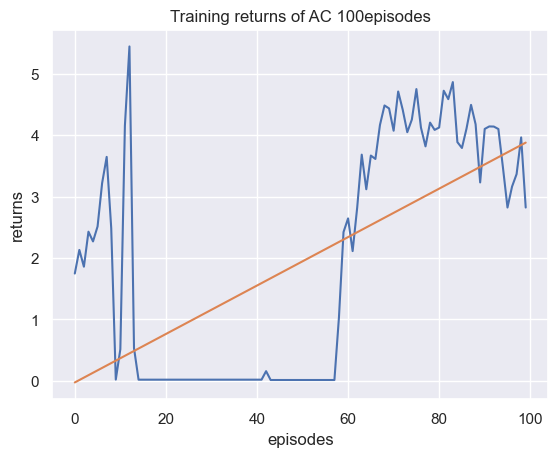

In [19]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(episode_rewards)
plt.ylabel('returns')
plt.xlabel('episodes')
plt.title(f'Training returns of AC {num_episodes}episodes')

reg = LinearRegression().fit(np.arange(len(episode_rewards)).reshape(-1, 1), np.array(episode_rewards).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(episode_rewards)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

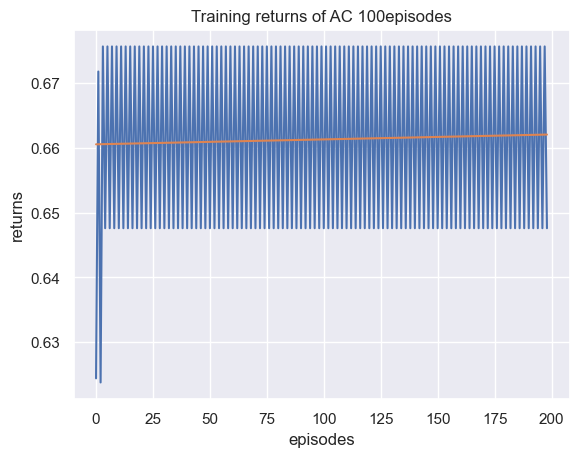

In [20]:
sns.set()

plt.plot(macro_f1_scores)
plt.ylabel('returns')
plt.xlabel('episodes')
plt.title(f'Training returns of AC {num_episodes}episodes')

reg = LinearRegression().fit(np.arange(len(macro_f1_scores)).reshape(-1, 1), np.array(macro_f1_scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(macro_f1_scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

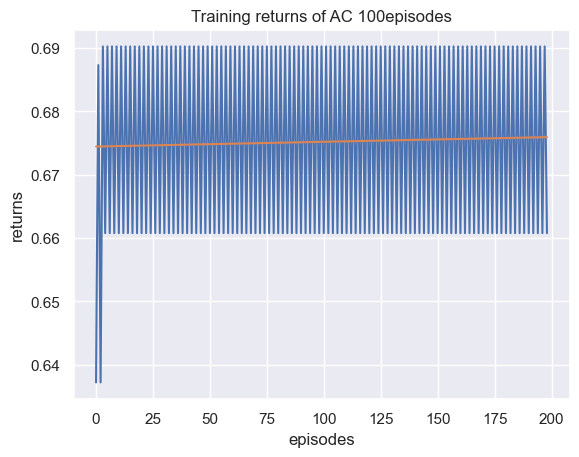

In [21]:
sns.set()

plt.plot(micro_f1_scores)
plt.ylabel('returns')
plt.xlabel('episodes')
plt.title(f'Training returns of AC {num_episodes}episodes')

reg = LinearRegression().fit(np.arange(len(micro_f1_scores)).reshape(-1, 1), np.array(micro_f1_scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(micro_f1_scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [22]:
# done = False
# state = env.reset()[0]
scores = []
f1_eval = []
micro_f1_eval = []
for test in tqdm(range(5)):
    state = env.get_state(reset=True)
    # state = torch.FloatTensor(state).unsqueeze(0)  # Shape adjustment for single sample
    done = False
    score = 0
    for step in range(200):
        #env.render()
        action_probs, state_value = actor_critic(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()

        # Take the chosen action and observe the next state and reward
        next_state, reward, f1, micro_f1 = env.step(action.item())
        next_state = torch.FloatTensor(next_state).unsqueeze(0)

        # next_state = torch.FloatTensor(next_state).unsqueeze(0)
        score += reward   
        state = next_state
        if test == 1:
            f1_eval.append(f1)
            micro_f1_eval.append(micro_f1)
    scores.append(score)

  0%|          | 0/5 [00:00<?, ?it/s]

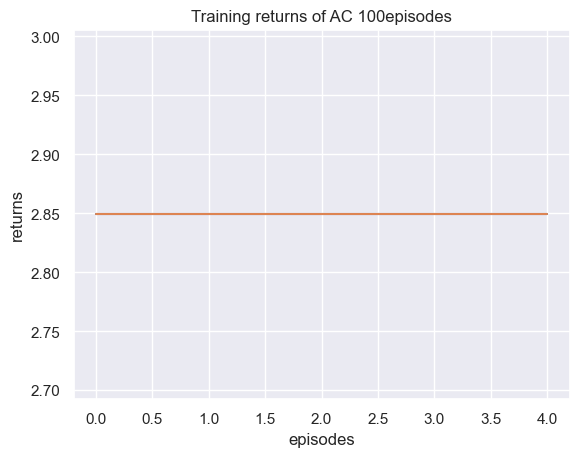

In [23]:
sns.set()

plt.plot(scores)
plt.ylabel('returns')
plt.xlabel('episodes')
plt.title(f'Training returns of AC {num_episodes}episodes')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

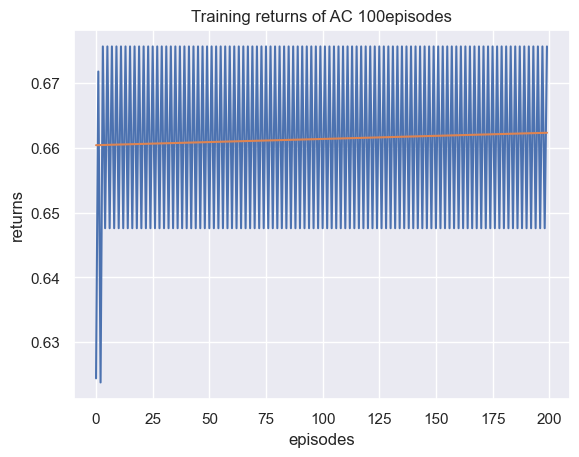

In [24]:
sns.set()

plt.plot(f1_eval)
plt.ylabel('returns')
plt.xlabel('episodes')
plt.title(f'Training returns of AC {num_episodes}episodes')

reg = LinearRegression().fit(np.arange(len(f1_eval)).reshape(-1, 1), np.array(f1_eval).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(f1_eval)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

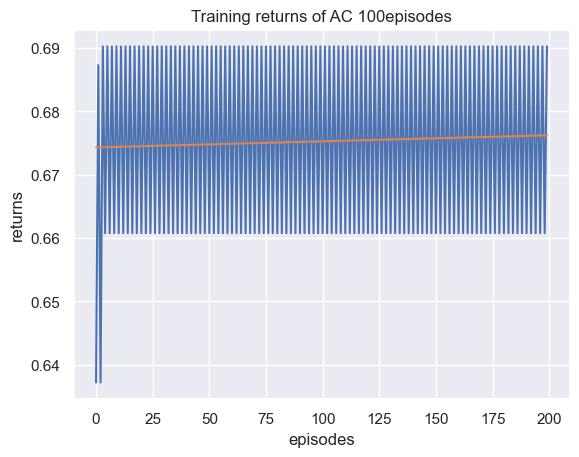

In [25]:
sns.set()

plt.plot(micro_f1_eval)
plt.ylabel('returns')
plt.xlabel('episodes')
plt.title(f'Training returns of AC {num_episodes}episodes')

reg = LinearRegression().fit(np.arange(len(micro_f1_eval)).reshape(-1, 1), np.array(micro_f1_eval).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(micro_f1_eval)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [26]:
#SAVING THE NETWORK.
import os

cwd = os.getcwd()

# Assume `model` is your neural network
torch.save(actor_critic.state_dict(), cwd+'/AC_20ng.pth')


In [27]:
env.get_f1()

(0.6756388277670605, 0.6902654867256637)

In [28]:
env.get_state(reset=True)

tensor([[5.0000e-01, 0.0000e+00, 0.0000e+00, 5.0000e-01, 2.3758e-01, 1.3970e-03,
         1.6008e-02, 7.4501e-01, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.8468e-03, 1.3350e-03, 9.8719e-01, 9.6299e-03, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0186e-03, 9.8604e-01, 9.1804e-03, 3.7580e-03,
         0.0000e+00, 0.0000e+00, 9.0000e-01, 1.0000e-01, 2.7256e-03, 8.9712e-04,
         9.7144e-01, 2.4934e-02, 3.0000e-01, 0.0000e+00, 0.0000e+00, 7.0000e-01,
         1.3671e-01, 5.3784e-03, 1.1810e-02, 8.4611e-01, 0.0000e+00, 1.0000e-01,
         9.0000e-01, 0.0000e+00, 5.9716e-03, 3.9848e-03, 9.5537e-01, 3.4675e-02,
         5.0000e-01, 0.0000e+00, 0.0000e+00, 5.0000e-01, 4.5514e-01, 2.4780e-03,
         1.6392e-02, 5.2599e-01, 0.0000e+00, 9.0000e-01, 1.0000e-01, 0.0000e+00,
         5.6693e-03, 7.9118e-01, 1.6741e-01, 3.5746e-02, 0.0000e+00, 9.0000e-01,
         1.0000e-01, 0.0000e+00, 1.0421e-03, 9.4978e-01, 4.0659e-02, 8.5150e-03,
         1.0000e-01, 0.0000e

In [29]:
model1_pred = env.models[0].predict(env.X_eval)
# Calculate F1 scores per class (harmonic means)
model1_f1_macro = f1_score(env.y_eval, model1_pred, average='macro')
model1_f1_micro = f1_score(env.y_eval, model1_pred, average='micro')

In [30]:
print(model1_f1_macro)
print(model1_f1_micro)

0.6541058720936975
0.6666666666666666


In [31]:
model2_pred = env.models[1].predict(env.X_eval)
# Calculate F1 scores per class (harmonic means)
model2_f1_macro = f1_score(env.y_eval, model2_pred, average='macro')
model2_f1_micro = f1_score(env.y_eval, model2_pred, average='micro')

In [32]:
print(model2_f1_macro)
print(model2_f1_micro)

0.6536824435169101
0.6696165191740413


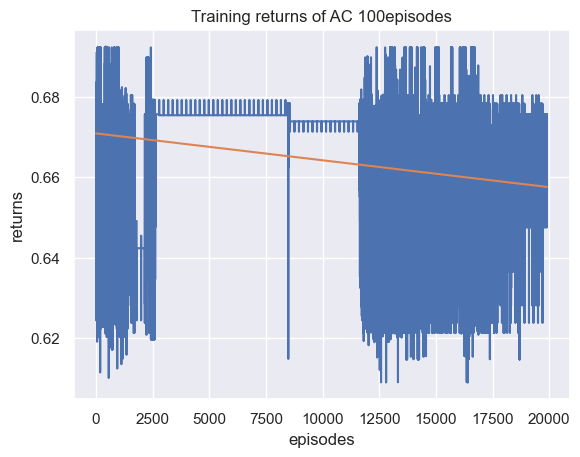

In [33]:
sns.set()

plt.plot(episode_f1)
plt.ylabel('returns')
plt.xlabel('episodes')
plt.title(f'Training returns of AC {num_episodes}episodes')

reg = LinearRegression().fit(np.arange(len(episode_f1)).reshape(-1, 1), np.array(episode_f1).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(episode_f1)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [40]:
len(episode_f1)
new_episode_f1 = [episode_f1[i] for i in range(len(episode_f1)) if i % 200 == 0]

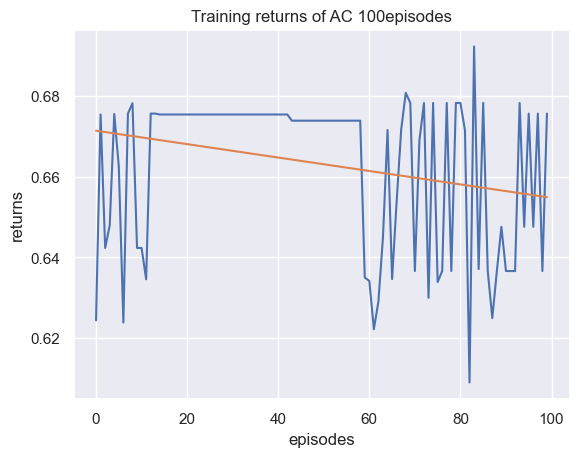

In [41]:
sns.set()

plt.plot(new_episode_f1)
plt.ylabel('returns')
plt.xlabel('episodes')
plt.title(f'Training returns of AC {num_episodes}episodes')

reg = LinearRegression().fit(np.arange(len(new_episode_f1)).reshape(-1, 1), np.array(new_episode_f1).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(new_episode_f1)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [39]:
import json

with open('20NG_episode_f1.json', 'w') as f:
    json.dump(episode_f1, f)

In [2]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


with open('20NG_episode_f1.json', 'r') as f:
    loaded_list = json.load(f)

len(loaded_list)

19900

In [3]:
def calculate_averages(numbers):
  """Calculates the average of every 10 consecutive numbers in a list.

  Args:
    numbers: A list of numbers.

  Returns:
    A list of averages, each representing the average of 10 consecutive numbers.
  """

  averages = []
  for i in range(0, len(numbers), 200):
    chunk = numbers[i:i+200]
    average = sum(chunk) / len(chunk)
    averages.append(average)
  return averages

# # Example usage:
# my_list = [1, 2, 3, ..., 200]  # Replace with your actual list of 200 numbers
result = calculate_averages(loaded_list)
# print(result)

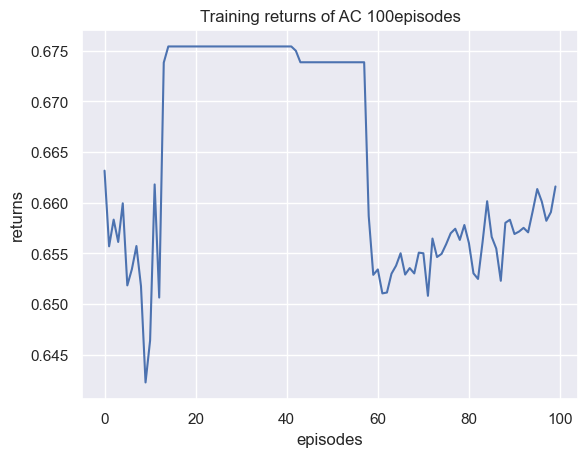

In [10]:
# len(episode_f1)
# result = [episode_f1[i] for i in range(len(episode_f1)) if i % 200 == 0]

sns.set()

plt.plot(result)
plt.ylabel('returns')
plt.xlabel('episodes')
plt.title(f'Training returns of AC {100}episodes')

# reg = LinearRegression().fit(np.arange(len(result)).reshape(-1, 1), np.array(result).reshape(-1, 1))
# y_pred = reg.predict(np.arange(len(result)).reshape(-1, 1))
# plt.plot(y_pred)
plt.show()